# Research Project 



#### Finding data
- BTC price from API? or from different sources (i started on this - trying to get daily prices from api)
- Oil, Gold, S&P 500 from Yahoo/Crsp/FactSet?
- Google trend - we can find google trend also through api --> pytrends: https://pypi.org/project/pytrends/
- Inflation, Interest rate in the US - CRSP or some other webpage with reliable info
+ Deciding whether we will use returns/ prices/ so on :)

In [1]:
#pip install pandas-datareader

In [197]:
import pandas_datareader.data as web
import pandas as pd
import datetime as dt
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.formula.api import ols
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic

In [74]:
# yahoo finance data
df1 = web.DataReader(['GC=F', 'CL=F', '^GSPC'], 'yahoo', start='2019-12-31', end='2022-01-18')["Adj Close"]
df1.rename(columns={'GC=F': 'GOLD', 'CL=F': 'OIL', '^GSPC': 'SP500'}, inplace=True)

In [75]:
# df1.tail()
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 518 entries, 2019-12-31 to 2022-01-18
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GOLD    518 non-null    float64
 1   OIL     518 non-null    float64
 2   SP500   516 non-null    float64
dtypes: float64(3)
memory usage: 16.2 KB


In [76]:
returns = df1.copy()
for i in range(1,len(df1+1)):
    returns.iloc[i] = np.log(df1.iloc[i]/df1.iloc[i-1])
returns = returns[1:]

/Users/nezasmid/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [77]:
# effective federal funds rate (https://fred.stlouisfed.org/series/EFFR)
df2 = web.DataReader(['EFFR'], 'fred', start='2020-01-01', end='2022-01-01')
df2.rename(columns={'EFFR': 'IR'}, inplace=True)
df2['IR']= df2['IR']/100

In [78]:
df2.head()

,IR
DATE,
2020-01-01,NaN
2020-01-02,0.0155
2020-01-03,0.0155
2020-01-06,0.0155
2020-01-07,0.0155


In [79]:
df = returns.merge(df2, how= 'left', left_index = True, right_index = True)

In [80]:
# df.info()
df.head()
# df.tail()

,GOLD,OIL,SP500,IR
Date,,,,
2020-01-02,0.003285,0.001963,0.008344,0.0155
2020-01-03,0.016072,0.030108,-0.007085,0.0155
2020-01-06,0.010914,0.003483,0.003527,0.0155
2020-01-07,0.003569,-0.009050,-0.002807,0.0155
2020-01-08,-0.009204,-0.050538,0.004890,0.0155


In [81]:
df3 = web.DataReader(['CPIAUCSL'], 'fred', start='2019-11-30', end='2022-01-01')
df3.rename(columns={'CPIAUCSL': 'INFL'}, inplace=True)

In [82]:
infl = df3.copy()
for i in range(1,len(df3+1)):
    infl.iloc[i] = np.log(df3.iloc[i]/df3.iloc[i-1])
infl = infl[1:]
infl.head()

,INFL
DATE,
2020-01-01,0.001873
2020-02-01,0.000529
2020-03-01,-0.003231
2020-04-01,-0.006990
2020-05-01,-0.000976


In [83]:
#pip install pytrends

In [84]:
from pytrends.request import TrendReq
from pytrends import dailydata

Bitcoin_df = dailydata.get_daily_data('Bitcoin', 2020, 1, 2022, 1, geo = '')

Bitcoin:2020-01-01 2020-01-31
Bitcoin:2020-02-01 2020-02-29
Bitcoin:2020-03-01 2020-03-31
Bitcoin:2020-04-01 2020-04-30
Bitcoin:2020-05-01 2020-05-31
Bitcoin:2020-06-01 2020-06-30
Bitcoin:2020-07-01 2020-07-31
Bitcoin:2020-08-01 2020-08-31
Bitcoin:2020-09-01 2020-09-30
Bitcoin:2020-10-01 2020-10-31
Bitcoin:2020-11-01 2020-11-30
Bitcoin:2020-12-01 2020-12-31
Bitcoin:2021-01-01 2021-01-31
Bitcoin:2021-02-01 2021-02-28
Bitcoin:2021-03-01 2021-03-31
Bitcoin:2021-04-01 2021-04-30
Bitcoin:2021-05-01 2021-05-31
Bitcoin:2021-06-01 2021-06-30
Bitcoin:2021-07-01 2021-07-31
Bitcoin:2021-08-01 2021-08-31
Bitcoin:2021-09-01 2021-09-30
Bitcoin:2021-10-01 2021-10-31
Bitcoin:2021-11-01 2021-11-30
Bitcoin:2021-12-01 2021-12-31
Bitcoin:2022-01-01 2022-01-31


In [85]:
Bitcoin_df

,Bitcoin_unscaled,Bitcoin_monthly,isPartial,scale,Bitcoin
date,,,,,
2020-01-01,57,NaN,NaN,NaN,NaN
2020-01-02,67,NaN,NaN,NaN,NaN
2020-01-03,73,NaN,NaN,NaN,NaN
2020-01-04,65,NaN,NaN,NaN,NaN
2020-01-05,67,14.0,False,0.14,9.38
...,...,...,...,...,...
2022-01-11,77,35.0,NaN,0.35,26.95
2022-01-12,71,35.0,NaN,0.35,24.85
2022-01-13,70,35.0,NaN,0.35,24.50


In [86]:
path = os.path.join('data','BTC-USD-2.csv')

In [87]:
df_data = pd.read_csv(path)
df_data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [88]:
df_data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)

In [89]:
df_data['Date']=pd.to_datetime(df_data['Date'])

In [90]:
df_data.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

In [91]:
df_btc=df_data.set_index('Date')

In [92]:
returns_btc = df_btc.copy()
for i in range(1,len(df_btc+1)):
    returns_btc.iloc[i] = np.log(df_btc.iloc[i]/df_btc.iloc[i-1])
returns_btc = returns_btc[1:]

In [93]:
returns_btc

,Close
Date,
2020-01-02,-0.030273
2020-01-03,0.050172
2020-01-04,0.008915
2020-01-05,0.000089
2020-01-06,0.047161
...,...
2022-01-11,0.021633
2022-01-12,0.027994
2022-01-13,-0.031376


In [96]:
btc_merged=returns_btc.join(Bitcoin_df['Bitcoin_unscaled'])

In [97]:
btc_df= btc_merged.join(df)

In [98]:
btc_df

,Close,Bitcoin_unscaled,GOLD,OIL,SP500,IR
Date,,,,,,
2020-01-02,-0.030273,67,0.003285,0.001963,0.008344,0.0155
2020-01-03,0.050172,73,0.016072,0.030108,-0.007085,0.0155
2020-01-04,0.008915,65,NaN,NaN,NaN,NaN
2020-01-05,0.000089,67,NaN,NaN,NaN,NaN
2020-01-06,0.047161,78,0.010914,0.003483,0.003527,0.0155
...,...,...,...,...,...,...
2022-01-11,0.021633,77,0.011170,0.037508,0.009118,NaN
2022-01-12,0.027994,71,0.004718,0.017332,0.002814,NaN
2022-01-13,-0.031376,70,-0.003289,-0.006312,-0.014346,NaN


In [209]:
data_btc=btc_df.dropna()

In [210]:
data_btc

,Close,Bitcoin_unscaled,GOLD,OIL,SP500,IR
Date,,,,,,
2020-01-02,-0.030273,67,0.003285,0.001963,0.008344,0.0155
2020-01-03,0.050172,73,0.016072,0.030108,-0.007085,0.0155
2020-01-06,0.047161,78,0.010914,0.003483,0.003527,0.0155
2020-01-07,0.049527,91,0.003569,-0.009050,-0.002807,0.0155
2020-01-08,-0.010322,100,-0.009204,-0.050538,0.004890,0.0155
...,...,...,...,...,...,...
2021-12-27,-0.003334,45,-0.001713,0.023836,0.013744,0.0008
2021-12-28,-0.062151,46,0.001161,0.005411,-0.001011,0.0008
2021-12-29,-0.024336,45,-0.002821,0.007605,0.001401,0.0008


In [214]:
data_btc.rename(columns={"Bitcoin_unscaled": "GoogleTrend", "Close": "BTC_ret"}, inplace=True)

### Descriptives - get to know the data

array([[<AxesSubplot:title={'center':'BTC_ret'}>,
        <AxesSubplot:title={'center':'GoogleTrend'}>],
       [<AxesSubplot:title={'center':'GOLD'}>,
        <AxesSubplot:title={'center':'OIL'}>],
       [<AxesSubplot:title={'center':'SP500'}>,
        <AxesSubplot:title={'center':'IR'}>]], dtype=object)

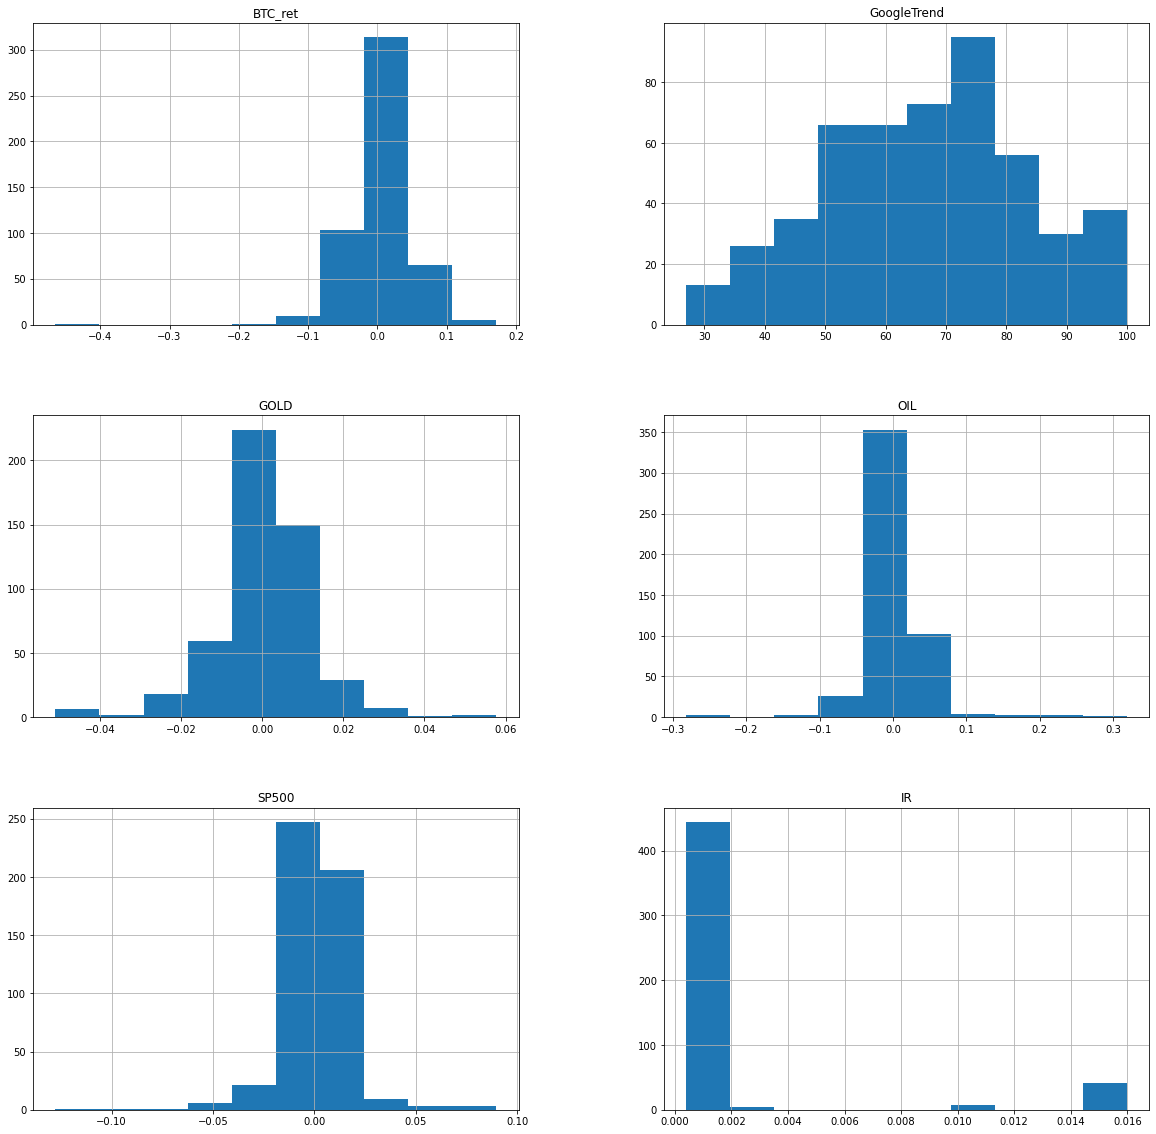

In [215]:
data_btc.hist(figsize=(20,20))

In [216]:
data_btc.describe()

,BTC_ret,GoogleTrend,GOLD,OIL,SP500,IR
count,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000
mean,0.003639,66.841365,0.000380,0.001927,0.000890,0.002232
std,0.045738,16.960272,0.011702,0.044265,0.016491,0.004284
min,-0.464730,27.000000,-0.051069,-0.282206,-0.127652,0.000400
25%,-0.016277,55.000000,-0.004395,-0.011828,-0.004561,0.000700
50%,0.002461,67.000000,0.000975,0.002528,0.001673,0.000800
75%,0.025754,78.000000,0.006125,0.016847,0.007933,0.000900
max,0.171821,100.000000,0.057775,0.319634,0.089683,0.016000


### Should we standardized/winsorized ? When doing histograms i did not see any outliers maybe not necessary ?

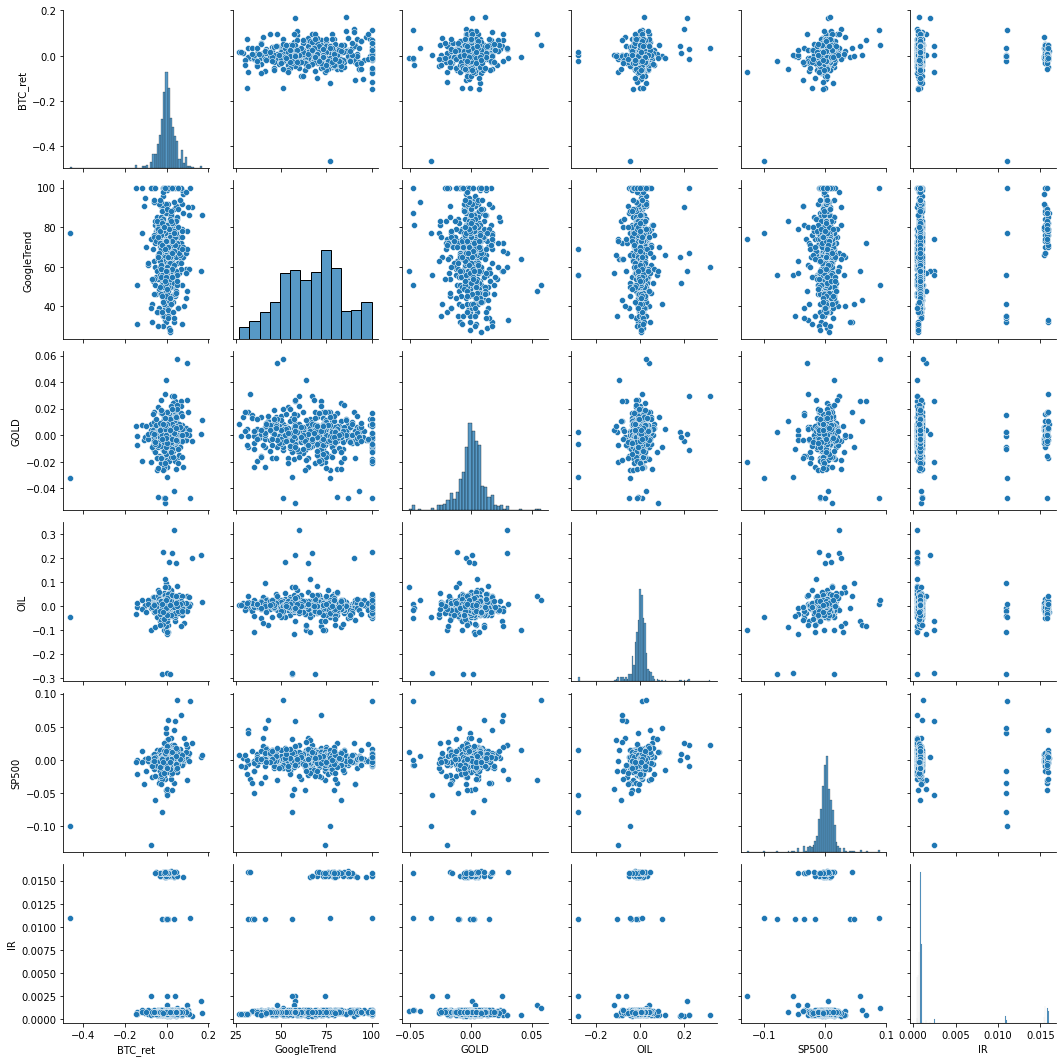

In [217]:
sns.pairplot(data_btc)

### Dickey-Fuller test (if needed)

https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
https://www.statology.org/dickey-fuller-test-python/
https://www.hackdeploy.com/augmented-dickey-fuller-test-in-python/

In [219]:
result = adfuller(data_btc.BTC_ret, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -5.7957834121024066
n_lags: 4.755744636190434e-07
p-value: 4.755744636190434e-07
Critial Values:
   1%, -3.443849184997939
Critial Values:
   5%, -2.8674931065091105
Critial Values:
   10%, -2.569940776113236


In [220]:
result = adfuller(data_btc.GOLD, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -11.226344134223627
n_lags: 1.9562908238047218e-20
p-value: 1.9562908238047218e-20
Critial Values:
   1%, -3.4437112724287253
Critial Values:
   5%, -2.8674324209387345
Critial Values:
   10%, -2.569908433637385


In [221]:
result = adfuller(data_btc.OIL, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -4.360254329418174
n_lags: 0.0003487813730822662
p-value: 0.0003487813730822662
Critial Values:
   1%, -3.443849184997939
Critial Values:
   5%, -2.8674931065091105
Critial Values:
   10%, -2.569940776113236


In [222]:
result = adfuller(data_btc.SP500, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -6.063789099357868
n_lags: 1.195148593557008e-07
p-value: 1.195148593557008e-07
Critial Values:
   1%, -3.4437936797256317
Critial Values:
   5%, -2.867468682890213
Critial Values:
   10%, -2.5699277594606915


In [142]:
result = adfuller(data.IR, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -3.907332667792376
n_lags: 0.001981540562966316
p-value: 0.001981540562966316
Critial Values:
   1%, -3.4440184853599876
Critial Values:
   5%, -2.867567599912013
Critial Values:
   10%, -2.5699804779975883


In [223]:
result = adfuller(data_btc.GoogleTrend, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -7.2639336863960295
n_lags: 1.6538116105082766e-10
p-value: 1.6538116105082766e-10
Critial Values:
   1%, -3.4436298692815304
Critial Values:
   5%, -2.867396599893435
Critial Values:
   10%, -2.5698893429241916


In [237]:
#Def function for ADF, i found it on the internet :) --> same link as for the VAR
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")   

In [238]:
# ADF Test on each column
for name, column in data_btc.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "BTC_ret" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.7958
 No. Lags Chosen       = 10
 Critical value 1%     = -3.444
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GoogleTrend" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.2639
 No. Lags Chosen       = 2
 Critical value 1%     = -3.444
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GOLD" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  

This thing probably looks much nicer than what i did, one variable after another. I let both options in here, but for the final output we can use just one :)

### Correlation matirx

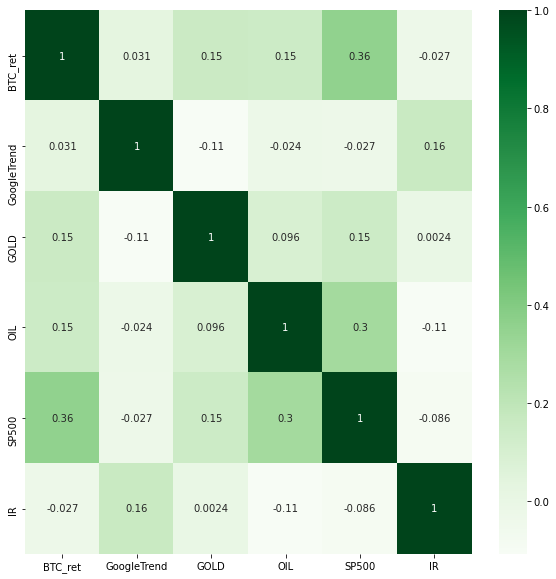

In [224]:
data_btc.corr()

# Plotting the seaborn heatmap 
fig = plt.figure(figsize=[10,10])
sns.heatmap(data_btc.corr(), annot=True, cmap="Greens")
plt.show()

In [226]:
data_btc.corr()

,BTC_ret,GoogleTrend,GOLD,OIL,SP500,IR
BTC_ret,1.000000,0.031256,0.154091,0.146747,0.358031,-0.027422
GoogleTrend,0.031256,1.000000,-0.105927,-0.023652,-0.026659,0.162033
GOLD,0.154091,-0.105927,1.000000,0.095802,0.147254,0.002396
OIL,0.146747,-0.023652,0.095802,1.000000,0.297962,-0.107532
SP500,0.358031,-0.026659,0.147254,0.297962,1.000000,-0.085995
IR,-0.027422,0.162033,0.002396,-0.107532,-0.085995,1.000000


### Classic OLS model
https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html

In [228]:
x=data_btc.drop(columns=['BTC_ret'])

In [230]:
y=data_btc.BTC_ret

In [190]:
#Model without the constant - just the variables also considering IR but we can replace it later
results = sm.OLS(y, x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Close   R-squared (uncentered):                   0.147
Model:                            OLS   Adj. R-squared (uncentered):              0.138
Method:                 Least Squares   F-statistic:                              16.97
Date:                Tue, 18 Jan 2022   Prob (F-statistic):                    1.72e-15
Time:                        22:58:34   Log-Likelihood:                          868.07
No. Observations:                 498   AIC:                                     -1726.
Df Residuals:                     493   BIC:                                     -1705.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
GoogleTrend  4.581e-05   3.18e-05      1.442      0.150   -1.66e-05       0.000
GOLD            0.4033      0.165      2.441      0.015       0.079       0.728
OIL             0.0391      0.045      0.862      0.389      -0.050       0.128
SP500           0.9189      0.122      7.506      0.000       0.678       1.159
IR             -0.0270      0.455     -0.059      0.953      -0.921       0.867
==============================================================================
Omnibus:                      182.735   Durbin-Watson:                   2.126
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2626.894
Skew:                          -1.180   Prob(JB):                         0.00
Kurtosis:                      14.001   Cond. No.                     1.65e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.65e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [233]:
model = ols("BTC_ret ~ OIL + GOLD + SP500 + GoogleTrend", data_btc)
fit = model.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                BTC_ret   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     20.52
Date:                Tue, 18 Jan 2022   Prob (F-statistic):           1.18e-15
Time:                        23:08:37   Log-Likelihood:                 868.46
No. Observations:                 498   AIC:                            -1727.
Df Residuals:                     493   BIC:                            -1706.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0069      0.008     -0.878      

#### VAR model
https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

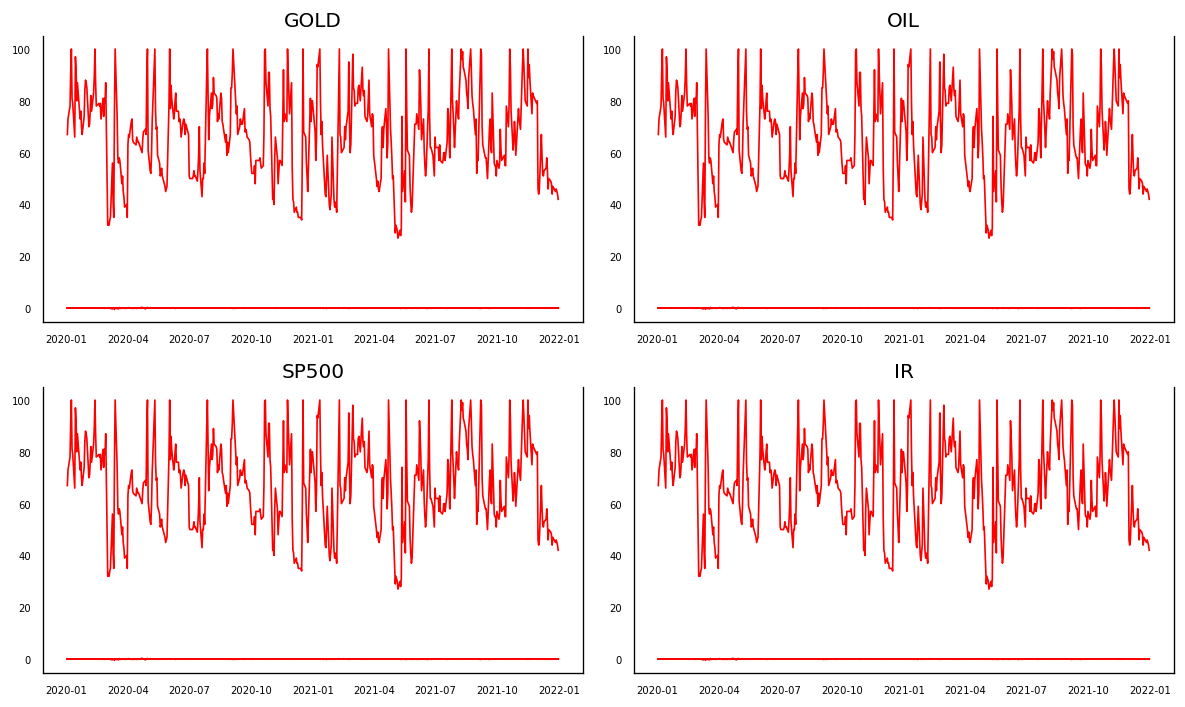

In [234]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = data_btc
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

#### If needed also ARDL